<a href="https://colab.research.google.com/github/nortonvanz/ML_Pocket_Reference/blob/main/notebooks/Titanic_pipeline_c2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resolução do Titanic utilizando CRISP-DM, seguindo o livro Machine Learning: Guia de Referência Rápica.

# Faça uma pergunta

Crie um modelo preditivo, que classifique se um indivíduo sobreviveu à catástrofe do Titanic (sim / não).

In [ ]:
#Dataset e problema original no Kaggle: https://www.kaggle.com/competitions/titanic/data?select=train.csv

## Ciclo 2

In [ ]:
#objetivo: melhorar a métrica acurácia obtida, ao subteter no Kaggle as predições do Ttitanic do ciclo 1: Kaggle score: 0.76555

In [ ]:
# melhorias possíveis:

  #Balanceamento de classes: class_weight='balanced'
  #fazer feature selection
  #testar modelos lineares


### Imports

In [21]:
#Análise de Colunas Colineares
#!pip install rfpimp
import rfpimp

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn           as sns
from collections             import Counter

from yellowbrick.features    import RFECV

from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose         import ColumnTransformer
from sklearn.metrics         import make_scorer, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix # balanced_accuracy_score,  , precision_recall_curve
from sklearn.ensemble        import RandomForestClassifier

from xgboost                 import XGBClassifier

### Aux Functions:

In [5]:
def standardize_cols(df):
  #converter tudo para minúsculo e com underline no lugar de espaços e pontos
  df.columns = df.columns.str.replace(' ','_').str.replace('.','_', regex=False).str.lower()
  return df

### Load Data

In [6]:
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/train.csv
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/test.csv

df_raw_train = pd.read_csv('train.csv')
df_raw_test = pd.read_csv('test.csv')

train.csv           100%[===================>]  59.76K  --.-KB/s    in 0.009s  
test.csv            100%[===================>]  27.96K  --.-KB/s    in 0.002s  


In [7]:
#padronizar nomes das colunas
df_raw_train = standardize_cols(df_raw_train)
df_raw_test = standardize_cols(df_raw_test)

In [8]:
df_train = df_raw_train.copy()
df_train.head(3)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Split Datasets

In [9]:
# Separação das variáveis independentes e dependente
X = df_train.drop(['survived'], axis=1)
y = df_train['survived'].copy()

# Separação entre treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# limpar vars
df_train=''

# usa na EDA pro SV:
# df_train = pd.concat([X_train, y_train], axis=1)
# df_train.head(2)

### Data Description

In [10]:
#dimensões
print(f'Linhas: {X_train.shape[0]}')
print(f'Colunas: {X_train.shape[1]}')

Linhas: 668
Colunas: 11


In [11]:
#tipos de dados
X_train.dtypes

passengerid      int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [12]:
#check nulos
X_train.isna().sum()

passengerid      0
pclass           0
name             0
sex              0
age            132
sibsp            0
parch            0
ticket           0
fare             0
cabin          519
embarked         2
dtype: int64

### Data Preparation

In [13]:
# inspect variations of each column
print(f"- Distinct values:\n{X_train.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{X_train.apply( lambda x: x.unique() ) } " )

- Distinct values:
passengerid    668
pclass           3
name           668
sex              2
age             83
sibsp            7
parch            7
ticket         529
fare           211
cabin          114
embarked         4
dtype: int64 

- Variations:
passengerid    [299, 885, 248, 479, 306, 317, 3, 406, 743, 26...
pclass                                                 [1, 3, 2]
name           [Saalfeld, Mr. Adolphe, Sutehall, Mr. Henry Jr...
sex                                               [male, female]
age            [nan, 25.0, 24.0, 22.0, 0.92, 26.0, 34.0, 21.0...
sibsp                                      [0, 1, 2, 4, 3, 8, 5]
parch                                      [0, 2, 1, 6, 4, 3, 5]
ticket         [19988, SOTON/OQ 392076, 250649, 350060, 11378...
fare           [30.5, 7.05, 14.5, 7.5208, 151.55, 26.0, 7.925...
cabin          [C106, nan, C22 C26, B57 B59 B63 B66, B28, C10...
embarked                                          [S, C, Q, nan]
dtype: object 


In [14]:
# dropar, assumindo não serem relevantes neste ciclo: passengerid, name, cabin (cabin tem quase metade das linhas com nulos), e ticket (números e letras, inúmeros códigos)
X_train = X_train.drop(columns=['passengerid','name', 'cabin', 'ticket'])
X_test = X_test.drop(columns=['passengerid','name', 'cabin', 'ticket'])

In [15]:
#converter categóricas com OHE:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [16]:
X_train.head(3)

,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
298,1,NaN,0,0,30.50,0,1,0,0,1
884,3,25.0,0,0,7.05,0,1,0,0,1
247,2,24.0,0,2,14.50,1,0,0,0,1


In [17]:
#remover sex_male, visto que tem o mesmo conteúdo de info de sex_female, mas oposto:
X_train = X_train.drop(columns=["sex_male"])
X_test = X_test.drop(columns=["sex_male"])

In [18]:
X_train.head(3)

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
298,1,NaN,0,0,30.50,0,0,0,1
884,3,25.0,0,0,7.05,0,0,0,1
247,2,24.0,0,2,14.50,1,0,0,1


In [19]:
#rodar um Xgb, apenas com CV e os melhores parâmetros do ciclo 1, e medir a acurácia atual:

pipe_xgb1 = Pipeline([
      ("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), #Substitui valores faltantes pela média, mediana, valor mais freq, ou valor constante.
      ("xgb", XGBClassifier() ) ]) #instancia XGBClassifier
pipe_xgb1.fit(X_train, y_train) #fit

# salvar o dataset X_train após ser transformado pelo cat_imputer, para usar no feature selection mais abaixo
X_train_cat = pipe_xgb1.named_steps['cat_imputer'].transform(X_train)
original_columns = X_train.columns
X_train_cat_imputer = pd.DataFrame(X_train_cat, columns=original_columns) #converter em DataFrame

In [20]:
params_xgb1 = {'xgb__min_child_weight': [5], 'xgb__max_depth': [4], 'xgb__learning_rate': [0.2], 'xgb__gamma': [0.1], 'xgb__colsample_bytree': [0.7]} #melhores params ciclo 1
grid_xgb1 = GridSearchCV(pipe_xgb1, cv=5, param_grid=params_xgb1) #GridSearchCV

grid_xgb1.fit(X_train, y_train) #pipe com GridSearchCV + xgb
xgb1_hat = grid_xgb1.predict(X_test) #predict
print(f'A acurácia foi: {accuracy_score(y_test, xgb1_hat)}') #score

A acurácia foi: 0.8251121076233184


In [23]:
#a acurácia de 0.825 acima foi atingida sem tratativas nos dados, apenas com CV e os melhores parâmetros do ciclo 1
#atingimos 0.829 no ciclo 1, com dados de teste, antes da submissão. Estamos muito parecidos em performance

### Feature Selection

In [24]:
X_train_cat_imputer.head(2)

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1.0,24.0,0.0,0.0,30.50,0.0,0.0,0.0,1.0
1,3.0,25.0,0.0,0.0,7.05,0.0,0.0,0.0,1.0


#### Remover features colineares

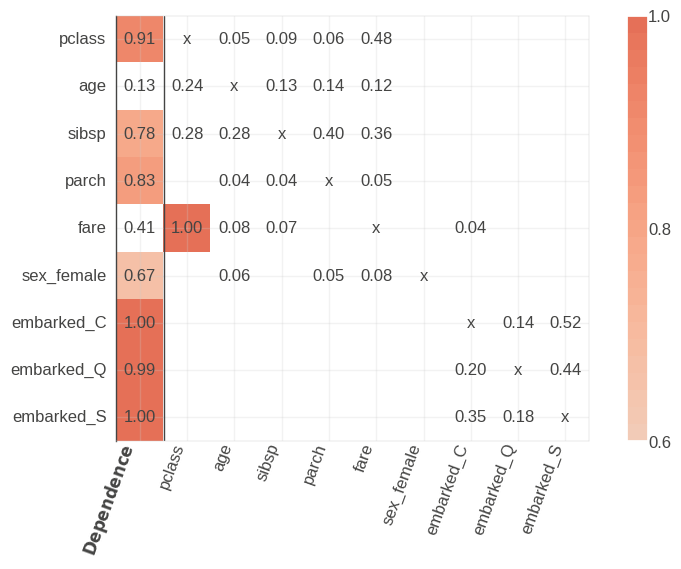

In [25]:
#Depanda passar pandas DataFrame, e não aceita nulos (questionável a utilidade)

#Uma estratégia para remover features desnecessárias é remover colunas colineares
#Podemos usar a função correlated_columns para encontrar colunas visualmente, colunas que tenham um coeficiente de correlação maior ou igual a 0,95:

#A função plot_dependence_heatmap faz o treinamento de uma random forest para cada coluna numérica a partir das outras colunas em um conjunto de dados de treinamento.
#O valor da dependência é a pontuação R2 das estimativas OOB (Out-Of-Bag) para a predição dessa coluna.

rfpimp.plot_dependence_heatmap(rfpimp.feature_dependence_matrix(X_train_cat_imputer),
value_fontsize=12,
label_fontsize=12)
fig = plt.gcf()
fig.set_size_inches(10, 6)

In [36]:
#A forma sugerida de usar esse gráfico é encontrar valores próximos de 1 no eixo Y (fora coluna Dependence).
#O rótulo no eixo X é o atributo que faz a predição do rótulo do eixo Y.
#Se um atributo faz a predição de outro, podemos remover o atributo previsto (o atributo no eixo Y).
#Como fare pode prever pclass, esta será removida, visto que a correlação é acima de 95%.

In [27]:
#remover pclass
X_train = X_train.drop(columns=["pclass"])
X_test = X_test.drop(columns=["pclass"])

#apenas para avaliação recursiva abaixo
X_train_cat_imputer = X_train_cat_imputer.drop(columns=["pclass"])

In [29]:
X_train_cat_imputer.head(2)

,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,24.0,0,0,30.50,0,0,0,1
1,25.0,0,0,7.05,0,0,0,1


#### Eliminação recursiva de features

RFECV(ax=<Axes: >, cv=5,
      estimator=RandomForestClassifier(class_weight='balanced', max_depth=2,
                                       n_estimators=300, random_state=42))

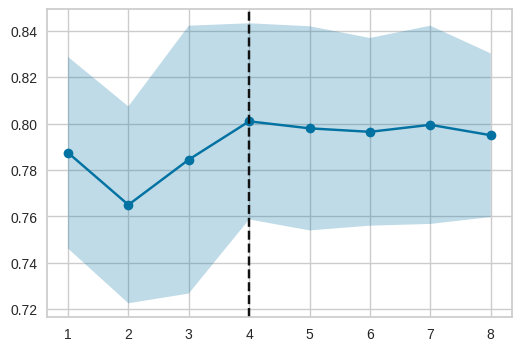

In [33]:
#A eliminação recursiva de atributos removerá os atributos mais fracos, e então treinará um modelo
#Será usada para encontrar as features mais importantes
  #PS: considerar que os parâmetros do modelo impactam

fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, max_depth=2),cv=5)
rfe.fit(X_train_cat_imputer, y_train)

In [36]:
X_train_cat_imputer.columns[rfe.support_]

Index(['age', 'sibsp', 'fare', 'sex_female'], dtype='object')

In [44]:
#Observando o gráfico acima, juntamente com o anterior, parece que as 3 features embarked não estão ajudando o modelo.
#Vamos remover elas, e gerar novamente o modelo, verificando se melhora sua performance.

In [37]:
X_train_cat_imputer_six_feat = X_train_cat_imputer.drop(columns=["embarked_C","embarked_Q","embarked_S"])
X_test_cat_imputer_six_feat = X_test.drop(columns=["embarked_C","embarked_Q","embarked_S"])

In [38]:
X_train_cat_imputer_six_feat.head(2)

,age,sibsp,parch,fare,sex_female
0,24.0,0,0,30.50,0
1,25.0,0,0,7.05,0


In [39]:
pipe_xgb2 = Pipeline([
      ("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), #Substitui valores faltantes pela média, mediana, valor mais freq, ou valor constante.
      ("xgb", XGBClassifier() ) ]) #instancia XGBClassifier
pipe_xgb2.fit(X_train_cat_imputer_six_feat, y_train) #fit

params_xgb2 = {'xgb__min_child_weight': [5], 'xgb__max_depth': [4], 'xgb__learning_rate': [0.2], 'xgb__gamma': [0.1], 'xgb__colsample_bytree': [0.7]} #melhores params ciclo 1
grid_xgb2 = GridSearchCV(pipe_xgb2, cv=5, param_grid=params_xgb2) #GridSearchCV

grid_xgb2.fit(X_train_cat_imputer_six_feat, y_train) #pipe com GridSearchCV + xgb
xgb2_hat = grid_xgb2.predict(X_test_cat_imputer_six_feat) #predict
print(f'A acurácia foi: {accuracy_score(y_test, xgb2_hat)}') #score

A acurácia foi: 0.8161434977578476


In [55]:
#O resultado caiu de 0.82 para 0.81, praticamente sem mudanças
#Avançar com X_train contendo as 8 colunas, e testar um xgboost balanceado

In [40]:
X_train.head(3)

,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
298,NaN,0,0,30.50,0,0,0,1
884,25.0,0,0,7.05,0,0,0,1
247,24.0,0,2,14.50,1,0,0,1


#### Categorical Vars

In [ ]:
#pular este bloco, pois as vars categóricas já foram resolvidas lá em cima com get_dummies.

In [ ]:
#cols que serão tratadas como categoricas, olhando a inspeção mais acima: pclass, sex, embarked

In [87]:
# variáveis categóricas
cat_columns = ['pclass','sex','embarked']
#cat_columns = list(X.select_dtypes(include=['object']).columns)

In [70]:
X_train[cat_columns].head(3)

In [ ]:
X_train[cat_columns].isna().sum()

pclass      0
sex         0
embarked    2
dtype: int64

In [ ]:
# pipeline variáveis cateǵoricas
  # SimpleImputer, resolvendo nulos de embarked
  # OneHotEncoder, gerando 1 coluna para cada categoria de cada uma das vas
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), #Substitui valores faltantes pela média, mediana, valor mais freq, ou valor constante.
                     ("ohe"        , OneHotEncoder(handle_unknown="ignore"))]) #Converte cada categoria em uma nova coluna. Aumenta a complexidade do dataset.


In [ ]:
cat_pipe

Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))])

#### Numerical Vars

In [41]:
X_train.head(2)

,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
298,NaN,0,0,30.50,0,0,0,1
884,25.0,0,0,7.05,0,0,0,1


In [42]:
#cols que serão tratadas como numéricas: pclass, age, sibsp, parch, fare
#as 4 outras são binárias

In [43]:
# variáveis numéricas
num_columns = ['age','sibsp','parch','fare']
#num_columns  = list(X.select_dtypes(include=['int64', 'float64']).columns)

In [44]:
X_train[num_columns].head(3)

,age,sibsp,parch,fare
298,NaN,0,0,30.50
884,25.0,0,0,7.05
247,24.0,0,2,14.50


In [45]:
X_train[num_columns].dtypes

age      float64
sibsp      int64
parch      int64
fare     float64
dtype: object

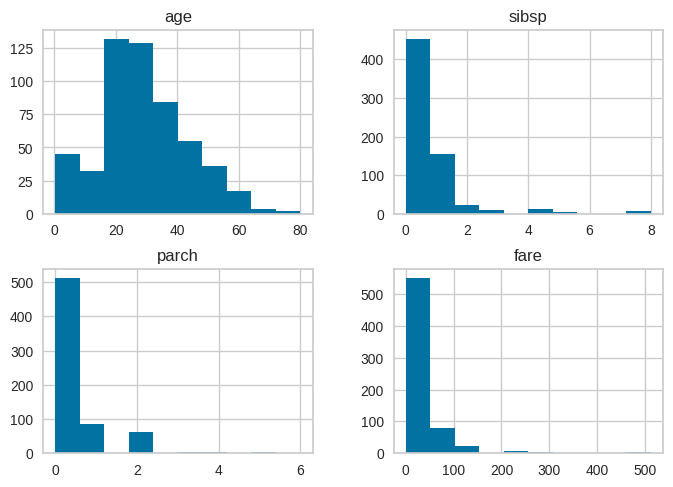

In [46]:
#visualizar distribuição das vars:
X_train[num_columns].hist();

In [ ]:
#a distribuição das vars não é normal, logo usar min-max-scaler

In [47]:
# pipeline variáveis numéricas

num_pipe = Pipeline([ ("num_imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
                     #("outliers"   , RobustScaler()), #Feature scaling p/ distribuição normal, com outliers.
                     #("scaler"     , StandardScaler())]) #Feature scaling p/ distribuição normal, sem outliers.
                      ("mms"        , MinMaxScaler())]) #Feature scaling p/ distribuição não normal, independente de outliers.


In [48]:
num_pipe

Pipeline(steps=[('num_imputer', SimpleImputer(strategy='median')),
                ('mms', MinMaxScaler())])

##### Exemplo de uso: num_pipe

In [ ]:
#pular

In [ ]:
#para utilizar o pipeline para realizar alguma das transformações: fitar, e em seguida chamar o step desejado, chamando o transform()

In [73]:
#fit
num_pipe.fit(X_train[num_columns], y_train)

In [ ]:
#obter dados após o num_imputer:
filled_nulls_data = num_pipe.named_steps['num_imputer'].transform(X_train[num_columns])
filled_nulls_data[0]

array([28. ,  0. ,  0. , 30.5])

In [ ]:
#obter dados, após a remoção de outliers:
outliers_transformed_data = num_pipe.named_steps['outliers'].transform(X_train[num_columns])
outliers_transformed_data[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


array([       nan, 0.        , 0.        , 0.71317829])

#### Preprocessing

In [49]:
# data preparation (aplica as transformações)
preprocessing = ColumnTransformer([#("categorica", cat_pipe, cat_columns), #já resolvido manualmente antes
                                   ("numerica", num_pipe, num_columns)])
preprocessing

ColumnTransformer(transformers=[('numerica',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('mms', MinMaxScaler())]),
                                 ['age', 'sibsp', 'parch', 'fare'])])

In [50]:
# agora, criar pipeline partindo deste preprocessing, e seguir com o Ggboost, agora tratando desbalanceamento, e avaliar o modelo

In [51]:
# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]  #scale_pos_weight = count(negative examples)/count(Positive examples)
print('Estimate: %.3f' % estimate)

Estimate: 1.605


In [52]:
pipe_xgb3 = Pipeline([
      ("preprocessing", preprocessing),
      ("xgb", XGBClassifier(scale_pos_weight=1.605) ) ])#lidar com desbalanceamento
pipe_xgb3.fit(X_train, y_train) #fit

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               earl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [55]:
params_xgb3 = {'xgb__min_child_weight': [5], 'xgb__max_depth': [4], 'xgb__learning_rate': [0.2], 'xgb__gamma': [0.1], 'xgb__colsample_bytree': [0.7]} #melhores params ciclo 1
grid_xgb3 = GridSearchCV(pipe_xgb3, cv=5, param_grid=params_xgb3, return_train_score=True) #GridSearchCV

grid_xgb3.fit(X_train, y_train) #pipe com GridSearchCV + xgb
xgb3_hat = grid_xgb3.predict(X_test) #predict
print(f'A acurácia foi: {accuracy_score(y_test, xgb3_hat)}') #score

A acurácia foi: 0.6995515695067265


In [ ]:
#O resultado piorou, caindo de 0.82 para 0.81, e agora para 0.69

In [56]:
#inspecionar overfitting
# Melhor modelo encontrado EM VALIDAÇÃO:
print("Best estimator: {}".format(grid_xgb3.best_estimator_))

Best estimator: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, device=None,
                               early...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importa

In [59]:
#Resultados que interessam (performance em TRAIN e VAL):
pd.set_option('max_colwidth', 100)
pd.DataFrame(grid_xgb3.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
0,1,"{'xgb__colsample_bytree': 0.7, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 4...",0.79603,0.637774


In [ ]:
#o modelo está overfitado, com performance em test (val) bem inferior à de treino, com os parâmetros fixos do ciclo 1
#Realizar um novo fine tuning, inclusive do parâmetro scale_pos_weight para balanceamento:

### Machine Learning + Fine Tuning

In [61]:
pipe_xgb4 = Pipeline([
      ("preprocessing", preprocessing),
      ("xgb", XGBClassifier() ) ])
pipe_xgb4.fit(X_train, y_train) #fit

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               earl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [82]:
# hiperparâmetros
xgb_hyperparams = {"xgb__max_depth"        : [ 2, 3, 4, 5, 8],
                   "xgb__gamma"            : [ 0.2, 0.3, 0.4, 0.5, 0.6 ],
                   "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
                   "xgb__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                   "xgb__learning_rate"    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                   "xgb__scale_pos_weight" : [ 0.6, 0.7, 0.75, 0.85, 1] }

In [83]:
accuracy          = make_scorer(accuracy_score)
scoring_dict      = {'accuracy': accuracy}

In [86]:
# Randomized Scearch Cross Validation
# In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.
# The number of parameter settings that are tried is given by n_iter.
pipe_xgb4_rscv = RandomizedSearchCV(
                          estimator=pipe_xgb4,
                          param_distributions=xgb_hyperparams,
                          n_iter = 50, #10
                          scoring = scoring_dict,
                          refit = 'accuracy',
                          n_jobs = -1,
                          cv = 5,
                          return_train_score=True,
                          random_state=42)

In [90]:
pipe_xgb4_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numerica',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('mms',
                                                                                                MinMaxScaler())]),
                                                                               ['age',
                                                                                'sibsp',
                                                                                'parch',
                                                                                'fare'])])),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            cols...
                   param_distributions={'xgb__colsample_bytree': [0.3, 0.4, 0.5,
                                                                  0.7],
                                        'xgb__gamma': [0.2, 0.3, 0.4, 0.5, 0.6],
                                        'xgb__learning_rate': [0.05, 0.1, 0.15,
                                                               0.2, 0.25, 0.3],
                                        'xgb__max_depth': [2, 3, 4, 5, 8],
                                        'xgb__min_child_weight': [1, 3, 5, 7],
                                        'xgb__scale_pos_weight': [0.6, 0.7,
                                                                  0.75, 0.85,
                                                                  1]},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score)})

In [81]:
#Resultados que interessam (performance em TRAIN e VAL):
pd.set_option('max_colwidth', 200)
pd.DataFrame(pipe_xgb4_rscv.cv_results_)[['rank_test_accuracy','params','mean_train_accuracy','mean_test_accuracy']].sort_values('rank_test_accuracy')[:5]

,rank_test_accuracy,params,mean_train_accuracy,mean_test_accuracy
5,1,"{'xgb__scale_pos_weight': 0.75, 'xgb__min_child_weight': 3, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__colsample_bytree': 0.4}",0.757482,0.702065
27,2,"{'xgb__scale_pos_weight': 0.5, 'xgb__min_child_weight': 5, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.15, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.4}",0.724926,0.691606
10,3,"{'xgb__scale_pos_weight': 1, 'xgb__min_child_weight': 1, 'xgb__max_depth': 12, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__colsample_bytree': 0.3}",0.791912,0.691583
9,4,"{'xgb__scale_pos_weight': 0.75, 'xgb__min_child_weight': 7, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.2, 'xgb__colsample_bytree': 0.5}",0.751870,0.690091
0,5,"{'xgb__scale_pos_weight': 0.75, 'xgb__min_child_weight': 7, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.2, 'xgb__colsample_bytree': 0.7}",0.753364,0.690080


In [ ]:
#Quando o melhor mean_test_score (score em VAL) for obtido uma extremidade de algum parâmetro (o maior ou menor valor), incluir outros valores ainda mais extremos,
# visando aumentar ainda mais a performance (e retirar os da outra extremidade, reduzindo o custo computacional.

In [ ]:
#Praticamente resolvido o overfitting do modelo

In [91]:
print(f'Os melhores parâmetros foram:\n{pipe_xgb4_rscv.best_params_}')
print(f'\nA melhor Acurácia foi: {pipe_xgb4_rscv.best_score_}')

Os melhores parâmetros foram:
{'xgb__scale_pos_weight': 0.7, 'xgb__min_child_weight': 5, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.7}

A melhor Acurácia foi: 0.7095387723038942


In [102]:
# Como mantivemos o (refit=True), chamando .score, o GridSearchCV retornará o score desse melhor modelo acima,
# pois já foi retreinado agora com todos os dados (TRAIN + VAL). No bloco acima, era contra VAL.
trainval_score = pipe_xgb4_rscv.score(X_train, y_train)
print("Acurácia: (TRAINVAL): {:.3f}".format(trainval_score))

Acurácia: (TRAINVAL): 0.728


In [101]:
#A acurácia está em 0.72, sem overfitting.

In [98]:
#Avaliar como o modelo se sai em TEST (dados inéditos, porem splitados no train_test_splito no início do projeto):
test_score = pipe_xgb4_rscv.score(X_test, y_test)
print("Acurácia (TEST): {:.3f}".format(test_score))

Acurácia (TEST): 0.704


In [107]:
#ou
y_hat_xgb4_rscv = pipe_xgb4_rscv.predict(X_test)
print(f'A acurácia foi: {round(accuracy_score(y_test, y_hat_xgb4_rscv),3)}')

A acurácia foi: 0.704


In [99]:
#Aceitável!

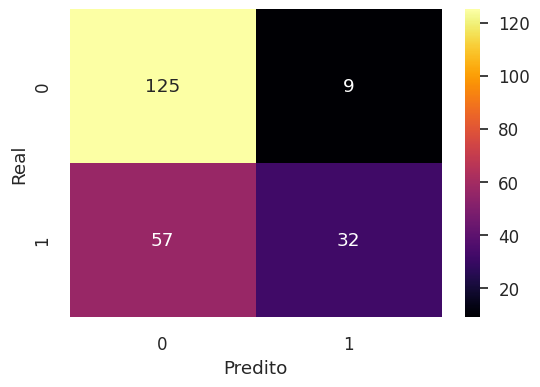

In [109]:
# Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, y_hat_xgb4_rscv)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predito'
plt.figure(figsize = (6, 4))
sns.set(font_scale=1.1)
sns.heatmap(df_cm, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

In [ ]:
#FN está bem legal: 9 apenas
#FP está bem ruim, 57 classificações erradas da classe positiva!
#seguir assim, neste ciclo

### Test Data

In [118]:
#Verificar agora, se o modelo performa bem, contra dados de teste do Kaggle (nunca antes vistos), simulando dados de produção:
df_raw_test.head(2)

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [ ]:
raw_test_score = pipe_xgb4_rscv.score(X_test, y_test)
print("Acurácia (TEST): {:.3f}".format(raw_test_score))

In [124]:
# predição em cima do dataset de teste Kaggle
y_pred_raw_test = pipe_xgb4_rscv.predict(df_raw_test)
y_pred_raw_test[:5]

array([0, 0, 0, 0, 0])

### Retreino para submissão

In [ ]:
  #Pular!

  #retreinar o melhor modelo agora com todo o dataset de treino do Kaggle:

  #Como mantivemos o (refit=True), chamando .score, o GridSearchCV retornará o score desse melhor modelo acima,
    # pois já foi retreinado com todos os dados (TRAIN + VAL).


In [112]:
df_train2 = df_raw_train.copy()
df_train2

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
#carregar dados originais
df_train = df_raw_train.copy()

# Separação das variáveis independentes e dependente
X = df_train.drop(['survived'], axis=1)
y = df_train['survived'].copy()

In [ ]:
# Retreino com o Pipeline do melhor resultado
pipe = result.best_estimator_
model = pipe.fit(X, y)

In [ ]:
#modelo final
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorica',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   RobustScaler()),
                                                                  ('scaler',
                                                                   Standa...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [ ]:
# predição em cima do dataset de teste Kaggle
y_pred = model.predict(df_raw_test)

### Kaggle Submission

In [121]:
#pegar df kaggle e converter no formato necessário
df_raw_test[['passengerid','parch']]

,passengerid,parch
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [122]:
# padroniza no formato esperado pelo Kaggle
df_sub = df_raw_test[['passengerid','parch']]
df_sub = df_sub.rename(columns={"passengerid": "PassengerId", "parch": "Survived"})

In [125]:
# atribui as previsões do modelo
df_sub['Survived'] = y_pred_raw_test

In [127]:
df_sub.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [128]:
#salvar arquivo para submeter
df_sub.to_csv('ciclo2_titanic_sub.csv', index=False)

In [ ]:
#Kaggle score: 0.68 (bem pior que da parte 2 do ciclo 1: 0.76)